In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax.nn import sigmoid
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from jax.nn import sigmoid
import matplotlib.pyplot as plt

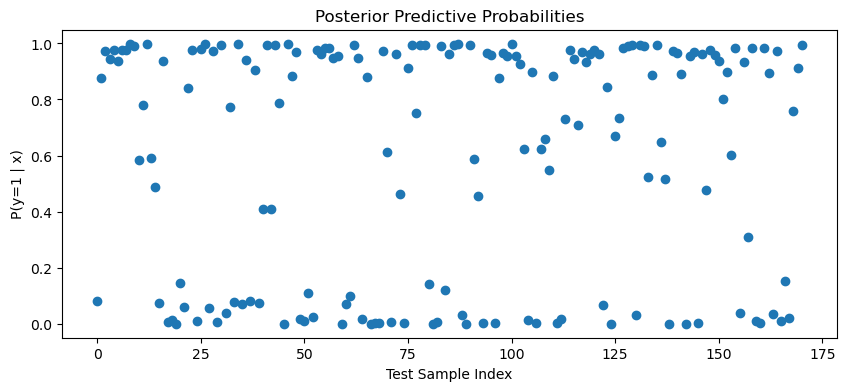

In [2]:
# Step 1: Load beta and intercept posterior samples
beta_samples = np.load("samples/beta_post_sparseclass_breast.npy")   # shape (8000, 30)
intercept_samples = np.load("samples/intercept_post_sparseclass_breast.npy")  # shape (8000,)

# Step 2: Load and standardize breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Step 4: Compute posterior predictive probabilities for test set
logits = np.dot(beta_samples, X_test.T) + intercept_samples[:, None]  # (8000, N_test)
probs = sigmoid(logits)  # P(y=1 | x) for each test sample

# Plot posterior predictive probabilities
plt.figure(figsize=(10, 4))
plt.plot(probs.mean(axis=0), 'o', label='Posterior Predictive Mean')
plt.xlabel('Test Sample Index')
plt.ylabel('P(y=1 | x)')
plt.title('Posterior Predictive Probabilities')
plt.show()

In [3]:
alpha = 0.2
mean_probs = probs.mean(axis=0)  # shape (N_test,)

def get_prediction_sets(mean_probs, alpha=0.2):
    sets = []
    for p in mean_probs:
        if p > 1 - alpha:
            sets.append({1})
        elif p < alpha:
            sets.append({0})
        else:
            sets.append({0, 1})
    return sets

prediction_sets = get_prediction_sets(mean_probs, alpha)


In [4]:
def compute_coverage(prediction_sets, y_true):
    contained = [y_true[i] in prediction_sets[i] for i in range(len(y_true))]
    return np.mean(contained)

coverage = compute_coverage(prediction_sets, y_test)
print(f"Bayes Coverage at α = {alpha}: {coverage:.3f}")

sizes = [len(s) for s in prediction_sets]
print("Prediction set sizes:")
print(f"  size 1: {sizes.count(1)}")
print(f"  size 2: {sizes.count(2)} (i.e., full uncertainty)")

all_coverages = []
all_avg_sizes = []

for seed in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=seed)

    logits = np.dot(beta_samples, X_test.T) + intercept_samples[:, None]
    probs = sigmoid(logits)
    mean_probs = probs.mean(axis=0)

    prediction_sets = get_prediction_sets(mean_probs, alpha)
    coverage = compute_coverage(prediction_sets, y_test)
    all_coverages.append(coverage)

    sizes = [len(s) for s in prediction_sets]
    avg_size = np.mean(sizes)  # ← true average size
    all_avg_sizes.append(avg_size)

print(f"Average coverage over 50 runs (Bayes): {np.mean(all_coverages):.3f}")
print(f"Average prediction set size over 50 runs: {np.mean(all_avg_sizes):.3f}")


Bayes Coverage at α = 0.2: 1.000
Prediction set sizes:
  size 1: 143
  size 2: 28 (i.e., full uncertainty)
Average coverage over 50 runs (Bayes): 0.997
Average prediction set size over 50 runs: 1.138


In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def split_cp_classification_paper(X, y, alpha=0.2, seed=42):
    """
    Split Conformal Prediction for classification,
    replicating paper setup: 70-30 train-test split, L1 penalty, α=0.2.
    """
    # 70/30 train-test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )
    
    # Split trainval into 50/50 for train/calibration
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_trainval, y_trainval, test_size=0.5, random_state=seed
    )
    
    # Train logistic regression with L1 penalty and λ = 1 → C = 1.0
    model = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=1.0,
        max_iter=1000,
        random_state=seed
    )
    model.fit(X_train, y_train)
    
    # Calibration probabilities
    cal_probs = model.predict_proba(X_cal)
    cal_scores = 1 - np.array([cal_probs[i, y_true] for i, y_true in enumerate(y_cal)])
    
    # Conformal quantile
    qhat = np.quantile(cal_scores, 1 - alpha)
    
    # Predict on test set
    test_probs = model.predict_proba(X_test)

    pred_sets = []
    for probs in test_probs:
        s = set()
        for cls in [0, 1]:
            score = 1 - probs[cls]
            if score <= qhat:
                s.add(cls)
        pred_sets.append(s)

    # Coverage and average size
    coverage = np.mean([y in s for y, s in zip(y_test, pred_sets)])
    avg_size = np.mean([len(s) for s in pred_sets])
    
    return pred_sets, coverage, avg_size, y_test, test_probs

coverages = []
avg_sizes = []

for seed in range(50):
    _, cov, size, *_ = split_cp_classification_paper(X, y, alpha=0.2, seed=seed)
    coverages.append(cov)
    avg_sizes.append(size)

print(f"Split CP — Average coverage over 50 runs: {np.mean(coverages):.3f}")
print(f"Split CP — Average prediction set size over 50 runs: {np.mean(avg_sizes):.3f}")


Split CP — Average coverage over 50 runs: 0.809
Split CP — Average prediction set size over 50 runs: 0.817


In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def full_cp_classification(X, y, alpha=0.2, lam=1.0, seed=42):
    """
    Full Conformal Prediction for classification using L1-penalized logistic regression.
    No calibration set; conformity scores are based on training predictions.
    """
    np.random.seed(seed)
    X, y = shuffle(X, y, random_state=seed)

    # Train-test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )

    # Train logistic model
    model = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=1.0 / lam,
        max_iter=1000,
        random_state=seed
    )
    model.fit(X_train, y_train)

    # Train conformity scores
    train_probs = model.predict_proba(X_train)
    train_scores = 1 - np.array([train_probs[i, y_train[i]] for i in range(len(y_train))])
    qhat = np.quantile(train_scores, 1 - alpha)

    # Test predictions
    test_probs = model.predict_proba(X_test)
    pred_sets = []
    for probs in test_probs:
        s = set()
        for cls in [0, 1]:
            score = 1 - probs[cls]
            if score <= qhat:
                s.add(cls)
        pred_sets.append(s)

    coverage = np.mean([y in s for y, s in zip(y_test, pred_sets)])
    avg_size = np.mean([len(s) for s in pred_sets])  # average size

    return coverage, avg_size

all_coverages = []
all_avg_sizes = []

for seed in range(50):
    coverage, avg_size = full_cp_classification(X, y, alpha=0.185, lam=1.0, seed=seed)
    all_coverages.append(coverage)
    all_avg_sizes.append(avg_size)

# Summary statistics
avg_coverage = np.mean(all_coverages)
avg_set_size = np.mean(all_avg_sizes)

print(f"Full CP (λ=1) — Average coverage over 50 runs: {avg_coverage:.3f}")
print(f"Full CP — Average prediction set size over 50 runs: {avg_set_size:.3f}")


Full CP (λ=1) — Average coverage over 50 runs: 0.812
Full CP — Average prediction set size over 50 runs: 0.814


In [7]:
beta_samples = np.load("samples/beta_post_sparseclass_breast.npy")   # (T, D)
intercept_samples = np.load("samples/intercept_post_sparseclass_breast.npy")  # (T,)
T = beta_samples.shape[0]

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X = data.data
y = data.target
X = StandardScaler().fit_transform(X)

# Split into calibration and test set
X_cal, X_test, y_cal, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
n_cal = len(X_cal)
n_test = len(X_test)

import jax.numpy as jnp
from jax.nn import log_sigmoid

# Convert to JAX
X_cal_jax = jnp.array(X_cal)
y_cal_jax = jnp.array(y_cal)
X_test_jax = jnp.array(X_test)
beta_samples_jax = jnp.array(beta_samples)
intercept_samples_jax = jnp.array(intercept_samples)

# (T, D) @ (D, N) + (T, 1) => (T, N)
logits_cal = jnp.dot(beta_samples_jax, X_cal_jax.T) + intercept_samples_jax[:, None]
logits_test = jnp.dot(beta_samples_jax, X_test_jax.T) + intercept_samples_jax[:, None]

# Compute log p(y | x) for calibration set
logp_samp_n = jnp.where(
    y_cal_jax == 1,
    log_sigmoid(logits_cal),         # log σ(θx)
    log_sigmoid(-logits_cal)         # log(1 - σ(θx))
)  # shape: (T, n_cal)

# For test points, compute log p(y=1|x) and log p(y=0|x)
logp_y1 = log_sigmoid(logits_test)     # shape: (T, n_test)
logp_y0 = log_sigmoid(-logits_test)

# Stack: for each test point, we have 2 hypotheses => shape (n_test*2, T)
logwjk = jnp.concatenate([
    logp_y0.T,  # for y=0
    logp_y1.T   # for y=1
], axis=0)  # shape: (2*n_test, T)


In [8]:
import jax.numpy as jnp
from jax.nn import log_sigmoid
from sklearn.model_selection import train_test_split
import numpy as np
from src.conformal_Bayes_functions import compute_cb_region_IS

def evaluate_bcp_classification(X, y, beta_samples, intercept_samples, alpha=0.2, seed=42):
    """
    Evaluate BCP on a classification task using 70-30 split, matching paper setup.
    Returns prediction sets, coverage, and mean_probs.
    """
    # Split: 70% train/calibration, 30% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )
    
    # Split trainval into 50/50 for train and calibration (like 35/35/30)
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_trainval, y_trainval, test_size=0.5, random_state=seed
    )
    
    # Convert to JAX arrays
    X_cal_jax = jnp.array(X_cal)
    y_cal_jax = jnp.array(y_cal)
    X_test_jax = jnp.array(X_test)
    beta_samples_jax = jnp.array(beta_samples)
    intercept_samples_jax = jnp.array(intercept_samples)
    
    # Compute log p(y_i | x_i, θ) for calibration points
    logits_cal = jnp.dot(beta_samples_jax, X_cal_jax.T) + intercept_samples_jax[:, None]
    logp_samp_n = jnp.where(
        y_cal_jax == 1,
        log_sigmoid(logits_cal),
        log_sigmoid(-logits_cal)
    )  # shape (T, n_cal)
    
    # Compute logits for test points
    logits_test = jnp.dot(beta_samples_jax, X_test_jax.T) + intercept_samples_jax[:, None]
    
    # Compute log p(y=1|x_test), log p(y=0|x_test)
    logp_y1 = log_sigmoid(logits_test)  # (T, n_test)
    logp_y0 = log_sigmoid(-logits_test)

    # Stack to form 2*n_test grid points for y=0 and y=1
    logwjk = jnp.concatenate([logp_y0.T, logp_y1.T], axis=0)  # shape: (2*n_test, T)

    # Run BCP region computation
    region_mask = compute_cb_region_IS(alpha, logp_samp_n, logwjk)  # shape: (2*n_test,)
    n_test = len(y_test)

    # Construct prediction sets from region mask
    pred_sets = []
    for i in range(n_test):
        s = set()
        if region_mask[i]:         # y=0
            s.add(0)
        if region_mask[n_test + i]:  # y=1
            s.add(1)
        pred_sets.append(s)
    
    # Compute posterior predictive mean (optional)
    probs = jnp.mean(sigmoid(logits_test), axis=0)
    
    # Coverage
    coverage = np.mean([y in s for y, s in zip(y_test, pred_sets)])
    
    return pred_sets, coverage, np.array(probs), y_test


In [9]:
from src.conformal_Bayes_functions import compute_cb_region_IS

alpha = 0.2
region_mask = compute_cb_region_IS(alpha, logp_samp_n, logwjk)  # shape (2 * n_test,)

# Turn boolean region mask into prediction sets
pred_sets = []
for i in range(n_test):
    pred_set = set()
    if region_mask[i]:              # index for y = 0
        pred_set.add(0)
    if region_mask[n_test + i]:     # index for y = 1
        pred_set.add(1)
    pred_sets.append(pred_set)

# Coverage and size
coverage = np.mean([y in s for y, s in zip(y_test, pred_sets)])
avg_size = np.mean([len(s) for s in pred_sets])

print(f"BCP conformal coverage: {coverage:.3f}")
print(f"BCP prediction set size: {avg_size:.3f}")

coverages = []
avg_sizes = []

for seed in range(50):
    pred_sets, coverage, *_ = evaluate_bcp_classification(
        X, y, beta_samples, intercept_samples, alpha=0.2, seed=seed
    )
    coverages.append(coverage)
    avg_sizes.append(np.mean([len(s) for s in pred_sets]))

print(f"BCP — Coverage over 50 runs: Avg = {np.mean(coverages):.3f}, Min = {np.min(coverages):.3f}, Max = {np.max(coverages):.3f}")
print(f"BCP — Avg prediction set size over 50 runs: {np.mean(avg_sizes):.3f}")


BCP conformal coverage: 0.813
BCP prediction set size: 0.813
BCP — Coverage over 50 runs: Avg = 0.812, Min = 0.719, Max = 0.889
BCP — Avg prediction set size over 50 runs: 0.814


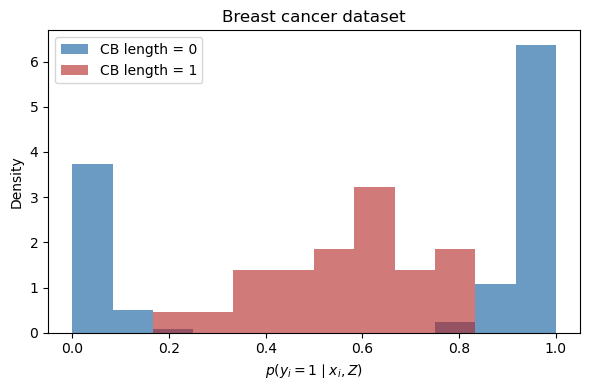

In [18]:
import matplotlib.pyplot as plt

def plot_cb_histogram(mean_probs, pred_sets, title="Breast cancer dataset"):
    """
    Plot posterior predictive probabilities split by CB prediction set length.
    """
    # Group by prediction set size
    probs_len_1 = [p for p, s in zip(mean_probs, pred_sets) if len(s) == 1]
    probs_len_2 = [p for p, s in zip(mean_probs, pred_sets) if len(s) == 2]
    
    # Plot histogram
    plt.figure(figsize=(6, 4))
    bins = np.linspace(0, 1, 13)

    plt.hist(probs_len_1, bins=bins, alpha=0.8, label="CB length = 0", color='steelblue', density=True)
    plt.hist(probs_len_2, bins=bins, alpha=0.6, label="CB length = 1", color='firebrick', density=True)

    plt.xlabel(r"$p(y_i=1 \mid x_i, Z)$")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

mean_probs = probs.mean(axis=0)
prediction_sets = get_prediction_sets(mean_probs, alpha)
plot_cb_histogram(mean_probs, prediction_sets)
